# Darcy Flow
Including forward and inverse problem solver for 1D. Darcy Flow
Darcy Flow
\begin{equation}
    \nabla \cdot ( k(x) \nabla u(x) ) = f(x)
\end{equation}

Zero Dirichlet boundary conditions $u(0) = u(1) = 0$

## Hints from Tim Sullivan

Express $u$ as $u(x) = \sum_{j = 1}^{n} u_{j} \phi_{j}(x)$ with $\phi_{j}(x) =$ piecewise linear tent function peaking at node $j$

Solve $A(u_{1}, …, u_{n}) = b$ for the coefficients  
\begin{align}
b_{j} &= \int_{0}^{1} f(x) \phi_{j}(x) d x \\
A_{i j} &= \int_{0}^{1} k(x) \phi'_{i}(x) \phi'_{j}(x) d x
\end{align}
Google finite element method / Galerkin method for elliptic PDE 

I will give you e.g. (u(1/4), u(1/2), u(3/4)) and similarly for f, both corrupted by additive N(0, \sigma^{2}) noise.
Your challenge:  infer k

--

Modelling assumption:  $k(x) = exp( \sum_{\alpha = 0}^{A} k_{\alpha} \phi_{\alpha}(x) )$

--

Try a Fourier basis. Note that u vanishes at the boundary, but that doesn't mean k does.

Create the forward model. Solver works. Extend to imitation inverse model with likelihood, etc. Use this to solve his problem.


# The Darcy Flow Problem

We consider the Darcy Flow problem in one dimension with Dirichlet boundry conditions and a modeling assumption.

\begin{align}
    k'(x) u'(x) + k(x) u''(x) &= f(x) \\
    u(0) = u(1) &= 0 \\
    exp( \sum_{\alpha = 0}^{A} k_{\alpha} \phi_{\alpha}(x) ) &=  k(x)
\end{align}

We put the equation into the weak form. $v(x)$ is a function which satisfies the boundary conditions.

\begin{equation}
    \int_{0}^{1} f(x)v(x) \ dx = \int_{0}^{1} (k'(x) u'(x) v(x) + k(x) u''(x) v(x)) \ dx
\end{equation}

We can integrate by parts and apply our boundry conditions on the second R.H.S. term to arrive at the next equation.

\begin{align}
    \int_{0}^{1} f(x)v(x) \ dx &= \int_{0}^{1} k'(x) u'(x) v(x) \ dx +
                                  k(x) u'(x) v(x) |_{0}^{1} - 
                                  \int_{0}^{1} k'(x) u'(x) v(x) \ dx - 
                                  \int_{0}^{1} k(x) u'(x) v'(x) \ dx \\
    \int_{0}^{1} f(x)v(x) \ dx &= - \int_{0}^{1} k(x) u'(x) v'(x) \ dx
\end{align}

We choose the piecewise linear function $v_k$ for a discretization.

\begin{equation}
v_{k}(x) = 
    \begin{cases}
        \frac{x-x_{k-1}}{x_k-x_{k-1}} & \text{if } x \in [x_{k-1}, x_k] \\
        \frac{x_{k+1}-x}{x_{k+1}-x_k} & \text{if } x \in [x_{k}, x_{k+1}] \\
        0 & \text{otherwise}
    \end{cases}
\end{equation}

If we expand $u(x)$ in a basis of tent functions on this discretization, we are left with the problem

\begin{equation}
    A \bf{u} = \bf{b}
\end{equation}

where $A_{ij} = - \int_{0}^{1} k(x) v_{i}'(x) v_{j}'(x) \ dx$ and $b_{j} = \int_{0}^{1} f(x) v_{j} dx$. Note that this will be a sparse matrix due our use of tent functions. With our modeling assumption, only 

## Useful Links
https://en.wikipedia.org/wiki/Finite_element_method  
http://www.mathematik.uni-dortmund.de/~kuzmin/Transport.pdf  

# Forward Solver

In [23]:
import numpy as np
import scipy.integrate
import matplotlib.pyplot as plt

np.random.seed(31)

In [24]:
def grid(nodes):
    return np.linspace(0, 1, num=nodes)
    
def tent(x, k, grid):
    def down(x):
        return (grid[k+1] - x) / (grid[k+1] - grid[k])
    def up(x):
        return (x - grid[k-1]) / (grid[k] - grid[k-1])
    if (k < 0) or (k > grid.size - 1):
        raise ValueError('k was not in [0, grid.size - 1]')
    elif k == 0:
        if (grid[k] <= x) and (x <= grid[k+1]):
            return down(x)
        else:
            return 0
    elif k == grid.size - 1:
        if (grid[k-1] <= x) and (x <= grid[k]):
            return up(x)
        else:
            return 0
    else:
        if (grid[k-1] <= x) and (x <= grid[k]):
            return up(x)
        elif (grid[k] <= x) and (x <= grid[k+1]):
            return down(x)
        else:
            return 0
        
def κ(x, coefs, grid):
    lo_bound = np.searchsorted(grid, x, 'left')
    up_bound = np.searchsorted(grid, x, 'right')
    
    if (0 - 0.1 <= x) and (x < grid[1]):
        return np.exp(sum([coefs[0] * tent(x, 0, grid), coefs[1] * tent(x, 1, grid)]))
    elif (grid[-2] < x) and (x <= grid[-1] + 0.1):
        return np.exp(sum([coefs[-2] * tent(x, grid.size - 2, grid), coefs[-1] * tent(x, grid.size - 1, grid)]))
    else:
        return np.exp(sum([coefs[k] * tent(x, k, grid) for k in [lo_bound, up_bound]]))
    
# def kappa(x, coefs, grid):
#     return np.exp(sum([coefs[k] * tent(x, k, grid) for k in range(grid.size)]))

def A(k, grid):
    val = lambda x, y: scipy.integrate.quad(k, x, y, limit=100)[0]
    lo_di = np.asarray([ val(grid[i-1], grid[i]  ) for i in range(2, grid.size - 1)])
    di    = np.asarray([-val(grid[i-1], grid[i+1]) for i in range(1, grid.size - 1)])
    up_di = np.asarray([ val(grid[i]  , grid[i+1]) for i in range(1, grid.size - 2)])
    
    return np.sum([np.diag(lo_di, -1), np.diag(di), np.diag(up_di, 1)], axis=0)

def b(f, grid):
    val = lambda x, y: scipy.integrate.quad(f, x, y)[0]
    return np.asarray([-val(grid[i-1], grid[i+1]) for i in range(1, grid.size - 1)])

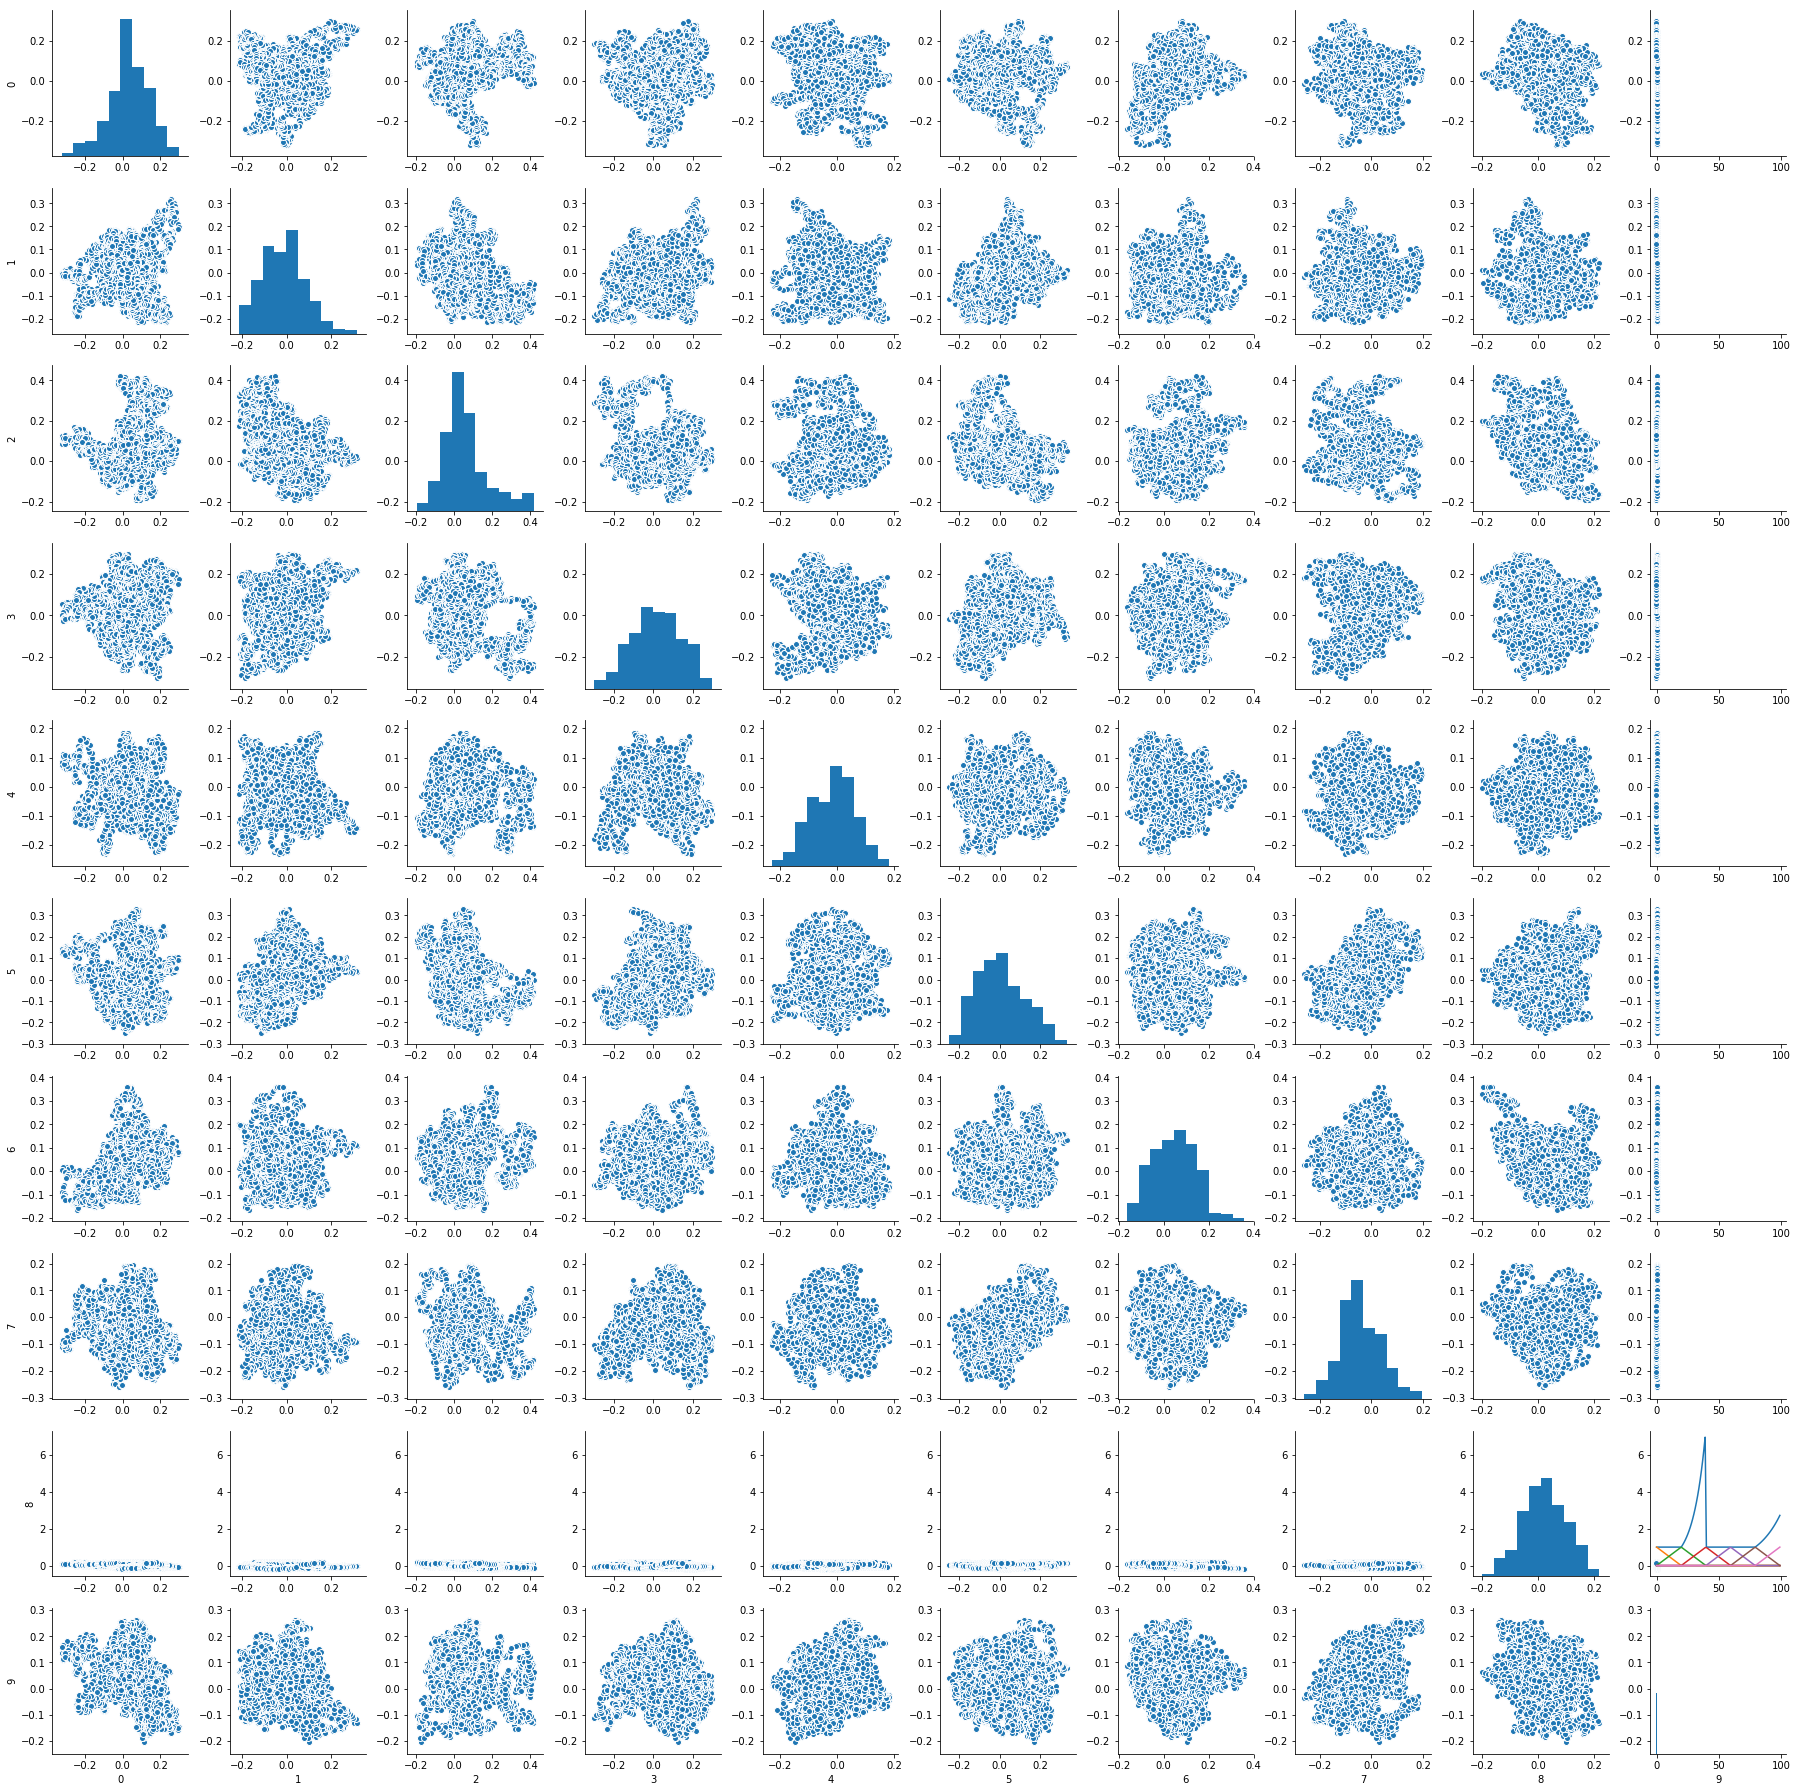

In [25]:
nodes = 6
g = grid(nodes)
plt.plot([κ(x, np.array([0,0,1,0,0,1]), g) for x in np.linspace(0, 1, num=100)])

for i in range(nodes):
    plt.plot([tent(x, i, g) for x in np.linspace(0, 1, num=100)])
plt.show()

In [26]:
nodes = 8
pars = np.random.randn(nodes)
g = grid(nodes)
aa = A(lambda x: κ(x, pars, g), g)
bb = b(lambda x: 1, g)

print(aa)
print(bb)
print(np.linalg.solve(aa, bb))

[[-0.25339759  0.15509423  0.          0.          0.          0.        ]
 [ 0.15509423 -0.22683167  0.07173744  0.          0.          0.        ]
 [ 0.          0.07173744 -0.18746018  0.11572273  0.          0.        ]
 [ 0.          0.          0.11572273 -0.18897495  0.07325221  0.        ]
 [ 0.          0.          0.          0.07325221 -0.14574055  0.07248834]
 [ 0.          0.          0.          0.          0.07248834 -0.39317869]]
[-0.28571429 -0.28571429 -0.28571429 -0.28571429 -0.28571429 -0.28571429]
[ 8.43791319 11.94391668 15.54101477 15.30192896 11.02380644  2.75908052]


# Forward Solver Using Tensorflow and Edward

In [27]:
# import edward as ed
# import tensorflow as tf
# from edward.models import Empirical, Normal

In [28]:
# mu = Normal(loc=0.0, scale=1.0)
# x = Normal(loc=mu, scale=1.0, sample_shape=10)

# qmu = Empirical(tf.Variable(tf.zeros(500)))
# inference = ed.SGHMC({mu: qmu}, {x: np.zeros(10, dtype=np.float32)})

In [29]:
# qmu_trace = qmu.params.eval()
# print(qmu_trace)

In [30]:
# plt.plot(x)
# plt.show()

# Inverse Problem

Given our Darcy Flow system, some coefficents of $u_{i}$ corrupted by additive noise $\mathcal{N}(0, \sigma^{2})$, and knowledge of $f(x)$, it is our job to infer the paramters $k_{\alpha}$. 

This section referse to a case where:

\begin{equation}
    - \frac{d}{dx}(e^{u(x)} \frac{dp}{dx}(x)) = f(x)
\end{equation}

Data, In this case, we assume we have 3 data points:

\begin{align}
    y &= [u(x_{1}), u(x_{4}), u(x_{9})] + \mathcal{N}(0, \sigma^{2})
\end{align}

Centered gaussian prior on u:

\begin{equation}
    \text{log prior density}(u) = - \sum_{k=1}^{A} \rho_k^2 (u_k)^2, \rho_k \sim \frac{1}{k}
\end{equation}

Write G for the u-to-y map, $G: \mathbb{R}^K \rightarrow \mathbb{R}^3$. (3 because we have 3 data points.)

\begin{equation}
    G(u) = [u(x_{1}), u(x_{4}), u(x_{9})]
\end{equation}

Gaussian observerd noise:

\begin{equation}
    \text{log likelihood}(u) = - \frac{1}{2 \sigma^2} ||G(u) - y||_{\mathbb{R}^3, 2}^{2}
\end{equation}

Log posterior to sample from (u|y)

\begin{equation}
    \text{log posterior}(u|y) = - \frac{1}{2 \sigma^2} ||G(u) - y||_{\mathbb{R}^3, 2}^{2} + \sum_{k=1}^{A} \rho_k^2 u_k^2
\end{equation}

The functions below use notation consistent with the forward solver

In [31]:
import scipy.stats
import seaborn as sns
import pandas as pd

In [32]:
# Random Walk MCMC Function
def metropolis_step(state, proposal_dist, target_dist):
    proposed_state = state + proposal_dist.rvs()

    acceptance_prob = min([0, target_dist(proposed_state) - target_dist(state)])

    if acceptance_prob > 0 or np.log(np.random.rand()) <= acceptance_prob:
        return proposed_state
    else:
        return state

In [33]:
def G_pre(k, f, grid):
    """(almost) Returns a vector of the forward solver given the vector of k_alphas."""
    aa = A(lambda x: κ(x, k, grid), grid)
    bb = b(f, grid)

    return aa, bb

def spec_metropolis_step(state, data, data_inds, noise_sigma, prop_sigma, prior_sigma, f, grid, verbose=False):
    def GG(f, grid):
        def gg(k):
            aa, bb = G_pre(k, f, grid)
            return np.linalg.solve(aa, bb)
        return gg
    
    G = GG(f, grid)
    
    proposal_dist = scipy.stats.multivariate_normal(np.zeros_like(grid),
                                                    np.eye(grid.shape[0]) * prop_sigma ** 2)
    proposed_state = state + proposal_dist.rvs()
    
#     alpha = (np.linalg.norm(data - G(state)[data_inds]) ** 2 -
#              np.linalg.norm(data - G(proposed_state)[data_inds]) ** 2) / (2 * noise_sigma ** 2)
#     alpha += (np.linalg.norm(state) ** 2 - np.linalg.norm(proposed_state)) / (2 * prop_sigma ** 2)

    err_state = np.linalg.norm(data - G(state)[data_inds]) ** 2
    err_props = np.linalg.norm(data - G(proposed_state)[data_inds]) ** 2
    norm_state = np.linalg.norm(state) ** 2
    norm_props = np.linalg.norm(proposed_state) ** 2

    if verbose:
        print('')
    
    alpha = (err_state - err_props) / (2 * noise_sigma ** 2) + (norm_state - norm_props) / (2 * prior_sigma ** 2)
    
#     alpha = (
#         (np.linalg.norm(data - G(state)[data_inds]) ** 2 -
#          np.linalg.norm(data - G(proposed_state)[data_inds]) ** 2) / (2 * noise_sigma ** 2) +
#         (np.linalg.norm(state) ** 2 - np.linalg.norm(proposed_state)) / (2 * prior_sigma ** 2)
#     )
    
    if alpha > 0 or np.log(np.random.rand()) <= alpha:
        return proposed_state
    else:
        return state
    

def target(data, data_inds, prior_k, prior_sigma, noise_sigma, f, grid):
    def logposterior(x):
        aa, bb = G_pre(x, f, grid)
        return -( 
            (1/(2 * noise_sigma**2) * (np.linalg.solve(aa, bb)[data_inds] - data) + 
             prior_k.norm / (2 * prior_sigma**2))
        )
    return logposterior

In [34]:
# MCMC Execution
nodes = 10
g = grid(nodes)
states = [np.zeros_like(g)]
steps = 100

data = np.asarray([1,.5,0.2])
data_inds = [0, 3, 7]
f = lambda x: 1

noise_sigma = 1
prop_sigma = 1
prior_sigma = 1/nodes

for i in range(steps):
    states.append(spec_metropolis_step(states[-1], 
                                       data,
                                       data_inds,
                                       noise_sigma,
                                       prop_sigma,
                                       prior_sigma,
                                       f,
                                       g))
    
states = np.asarray(states)

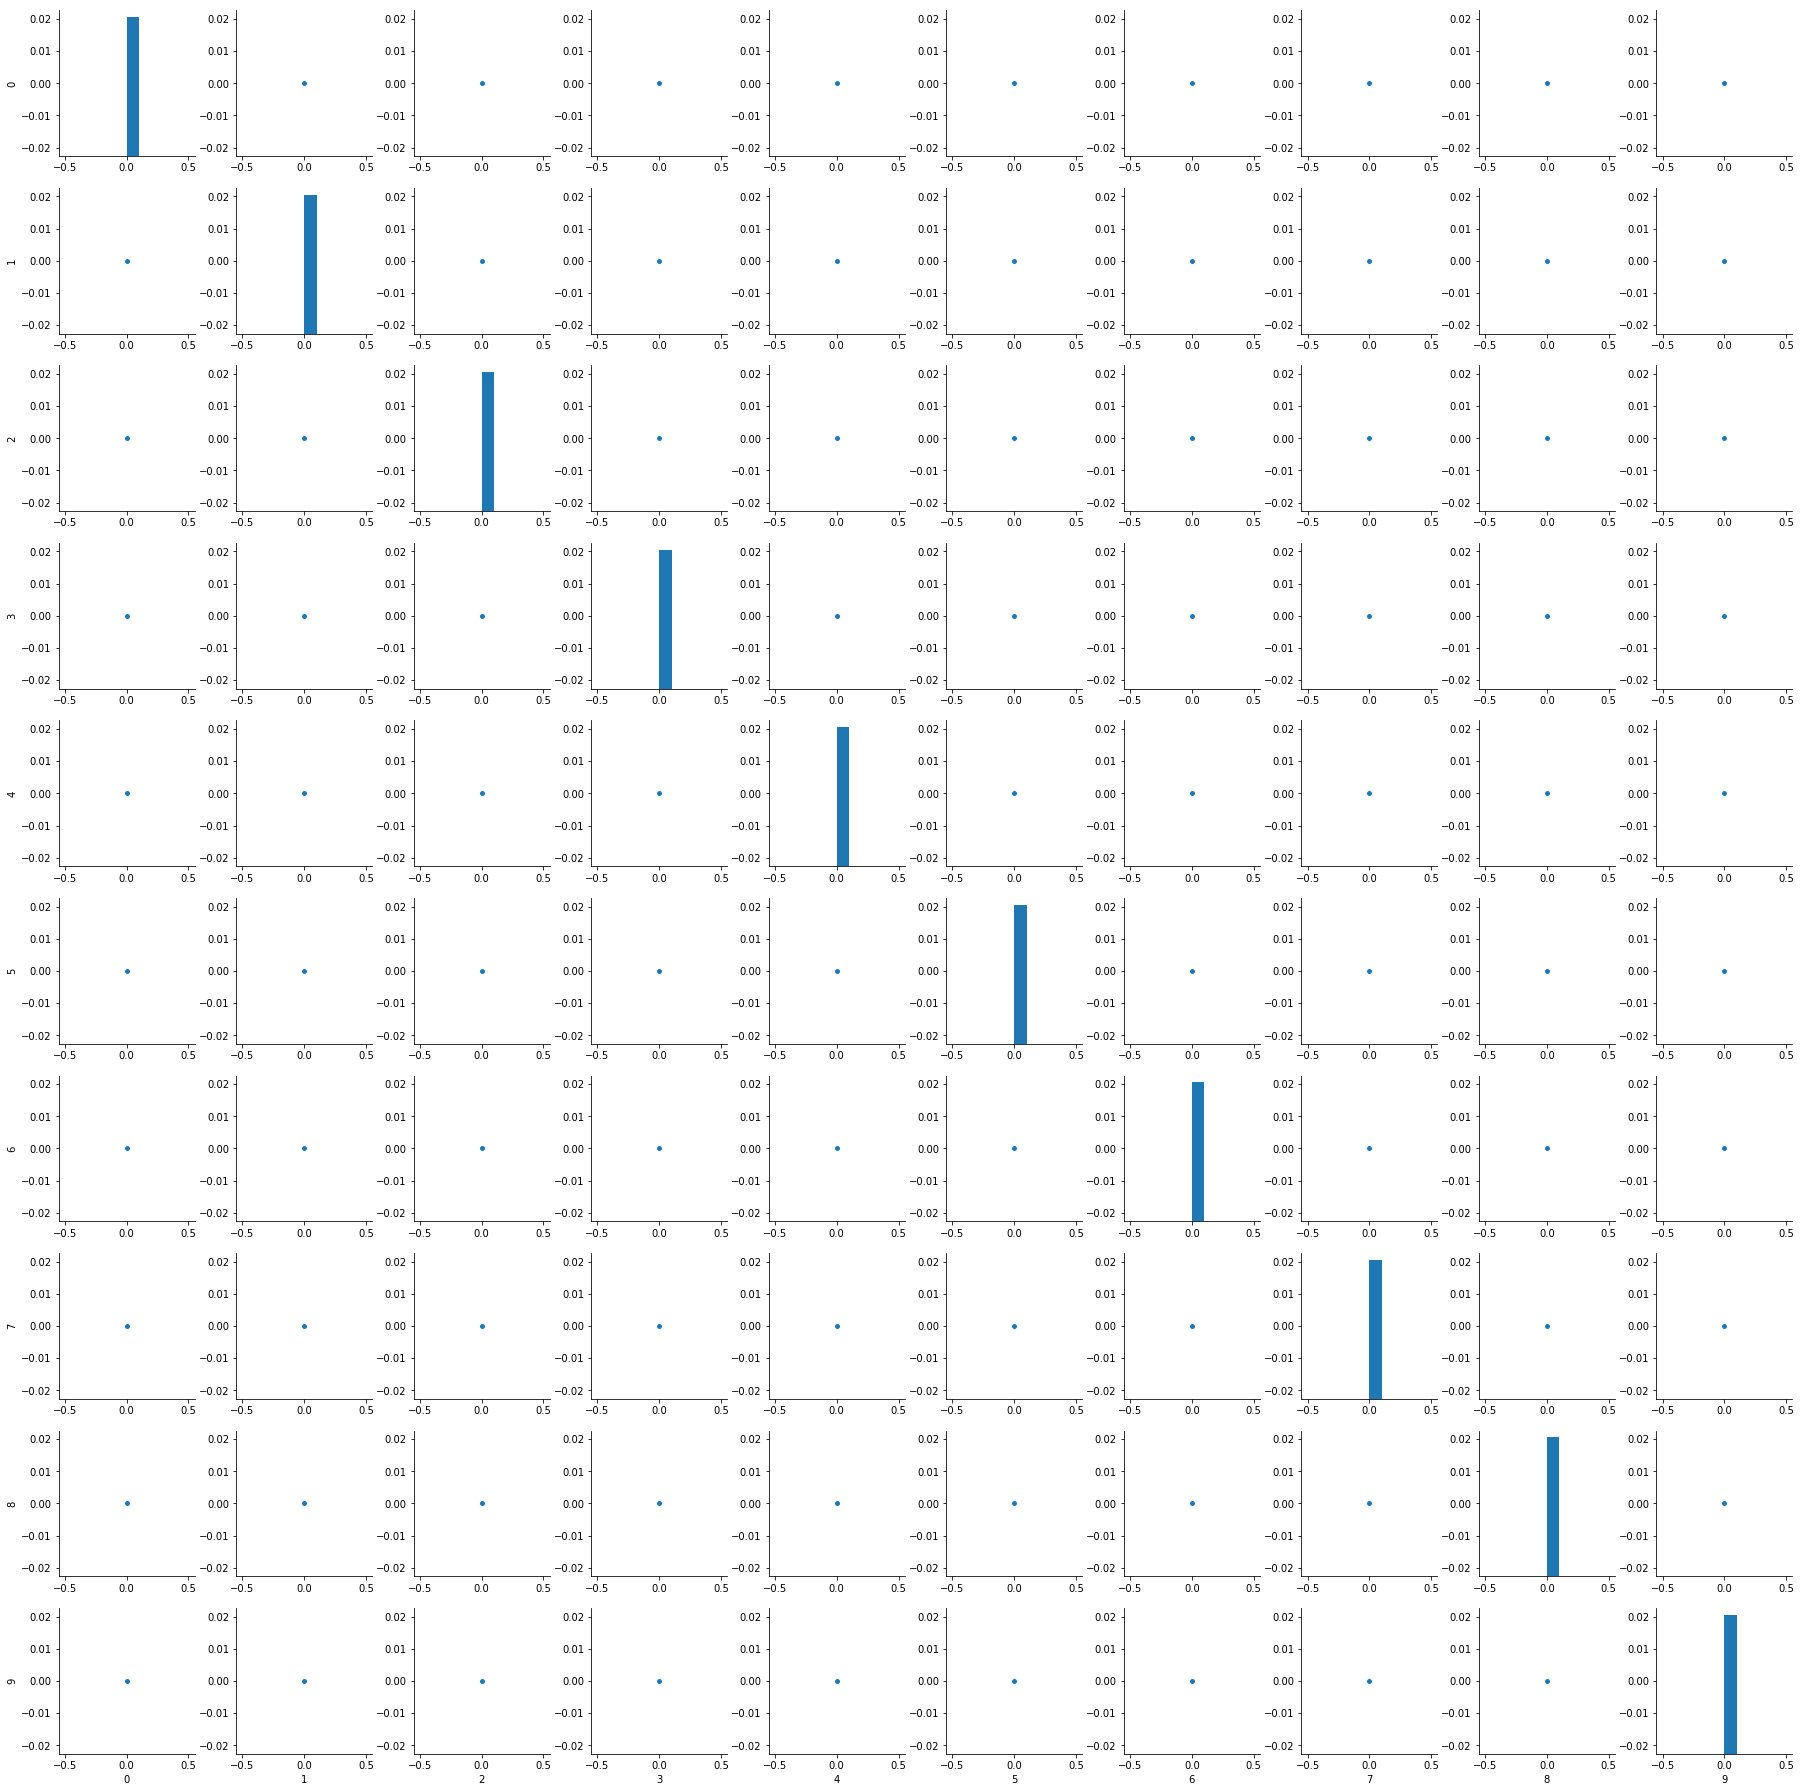

In [35]:
df = pd.DataFrame(states)
sns.pairplot(df)
plt.show()

# False Data Generation

[ 7.55320617 13.12255582 16.97598465 18.68842015 18.49980282 16.60311734
 12.62019066  7.69725429]


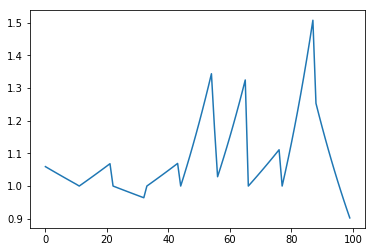

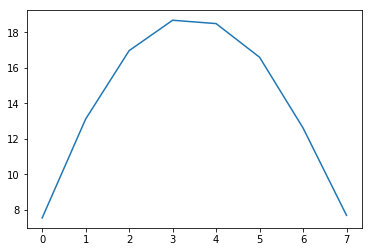

In [36]:
nodes = 10
param_distribution_sigma = 1/nodes
pars = param_distribution_sigma * np.random.randn(nodes)
g = grid(nodes)

k = lambda x: κ(x, pars, g)
f = lambda x: 1

aa = A(k, g)
bb = b(f, g)

soln = np.linalg.solve(aa, bb)
print(soln)

u = np.asarray([[x, k(x)] for x in np.linspace(0, 1, num=100)])
plt.plot(u[:, 1])
plt.show()
plt.plot(soln)
plt.show()

In [37]:
data_inds = list(range(len(g) -2)) # [0, 3, 7]
data = np.asarray([[g[i + 1], soln[i]] for i in data_inds])

corruption_sigma = 1

corrupted_data = data.copy()
corrupted_data[:, 1] += corruption_sigma * np.random.randn(len(data_inds))

print(data, '\n', corrupted_data)

[[ 0.11111111  7.55320617]
 [ 0.22222222 13.12255582]
 [ 0.33333333 16.97598465]
 [ 0.44444444 18.68842015]
 [ 0.55555556 18.49980282]
 [ 0.66666667 16.60311734]
 [ 0.77777778 12.62019066]
 [ 0.88888889  7.69725429]] 
 [[ 0.11111111  7.61807812]
 [ 0.22222222 14.47603144]
 [ 0.33333333 16.38072175]
 [ 0.44444444 16.90571951]
 [ 0.55555556 18.65086732]
 [ 0.66666667 15.55196449]
 [ 0.77777778 13.45603029]
 [ 0.88888889  7.25040464]]


# Recover params

In [38]:
states = [np.zeros_like(g)]
steps = 5000

noise_sigma = 1
prop_sigma = 1/nodes ** 2
prior_sigma = 1/nodes

for i in range(steps):
    try:
        states.append(spec_metropolis_step(states[-1], 
                                           corrupted_data[:, 1],
                                           data_inds,
                                           noise_sigma,
                                           prop_sigma,
                                           prior_sigma,
                                           f,
                                           g))
    except np.linalg.LinAlgError:
        continue
    
states = np.asarray(states)

In [39]:
df = pd.DataFrame(states)
sns.pairplot(df)
# plt.show()
plt.savefig('8_data_pts', format=None)

In [40]:
print(pars)

print(states.mean(axis=0))
print(np.abs(pars - states.mean(axis=0))/pars)

[ 0.05774977  0.00040051  0.03640374 -0.02007236  0.03684341  0.1625743
  0.1547157   0.05794422  0.22584341 -0.10271412]
[0.04737595 0.05516223 0.04351883 0.12250457 0.07108962 0.05451876
 0.02105254 0.07240837 0.09438258 0.04686689]
[  0.17963393 136.73113573   0.19544969  -7.10314628   0.92950694
   0.66465329   0.86392761   0.2496219    0.58208838  -1.45628473]


In [41]:
import pickle
pickle.dump( states, open( "samples_c.p", "wb" ) )

In [42]:
# smp = pickle.load( open( "samples_b.p", "rb" ) )
# smp = np.array(smp)
# smp